In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

# Loading data

In [2]:
from fastai.dataset import ImageClassifierData, tfms_from_model
from fastai.model import resnet34

## From path

Consider we have the following structure:
```
data  
└───dataset
│   │
│   └───train
|   |   └─── class1
|   |   └─── class2
|   |   └─── class3
│   └───valid
|   |   └─── class1
|   |   └─── class2
|   |   └─── class3
│   └───test
|       └─── class1
|       └─── class2
|       └─── class3
```
Where the image for each class is on a separate folder

Args:  
    * path: The path to the directory  
    * bs: batch size  
    * tfms: The transformations applied to the image, expects a tuple with two elements, the first is applied to the training data, the second to the test and validation data.
    * trn_name: Folder name of training data
    * val_name: Folder name of validation data
    * test_name: Folder name of test data

In [3]:
# Define the transformations to be used
# We can use the transformations pre-defined by a model, sz is the rescaled size of the image
tfms = tfms_from_model(resnet34, sz=224)

In [4]:
path = 'data/dogscats'
data = ImageClassifierData.from_paths(path, tfms=tfms,
                                      trn_name='train',
                                      val_name='valid',
                                      test_name=None)

# Data visualization

In [5]:
# Dataset classes
classes = data.classes
data.classes

['cats', 'dogs']

## Plot single image

In [6]:
idx = 1

Text(0.5,1,'cats')

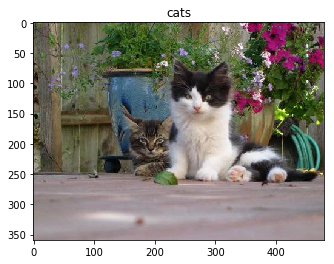

In [7]:
# Get original images
img = data.trn_ds.get_x(idx)
label = data.trn_ds.get_y(idx)
plt.imshow(img)
plt.title(classes[label])

Text(0.5,1,'cats')

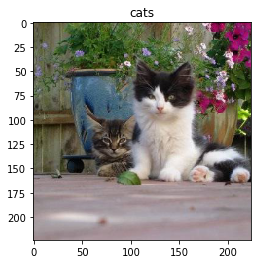

In [8]:
# Get transformed images
img, label = data.trn_ds[idx]
denorm_img = data.trn_ds.denorm(img)
plt.imshow(denorm_img[0])
plt.title(classes[label])

## Plot multiple images

In [9]:
from fastai.plots import plots

In [10]:
def plot_images(dataset, idxs, **kwargs):        
    imgs, _ = zip(*[dataset[idx] for idx in idxs])
    imgs = np.array(imgs)
    denorm_imgs = dataset.denorm(imgs)
        
    plots(denorm_imgs, **kwargs)

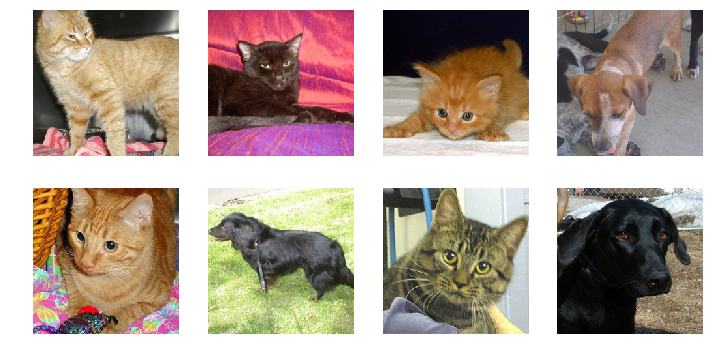

In [11]:
# Plot random images
num_train_imgs = data.trn_ds.get_n()
idxs = np.random.choice(num_train_imgs, size=8, replace=False)

plot_images(data.trn_ds, idxs, rows=2)

In [12]:
def softmax(values):
    exp_values = np.exp(values)
    return exp_values / np.sum(exp_values, axis=1)[:, np.newaxis]

In [13]:
# Generate fake preds
size = data.val_ds.n
num_classes = data.c

fake_probs = softmax(np.random.uniform(size=[size, num_classes]))
fake_preds = np.argmax(fake_probs, axis=1)

In [14]:
def plot_incorrect(dataset, probs, max_num_images=4, from_class=None, **kwargs):
    labels = dataset.y
    preds = np.argmax(probs, axis=-1)
    wrong_preds_idxs = np.where(preds != labels)[0]
    labels = labels[wrong_preds_idxs]
    
    if from_class is not None:
        wrong_preds_idxs = wrong_preds_idxs[labels == from_class]
        
    idxs = np.random.choice(wrong_preds_idxs, size=max_num_images)
        
    plot_images(dataset, idxs, titles=probs[idxs, :3]) #Only plot first 3 probs

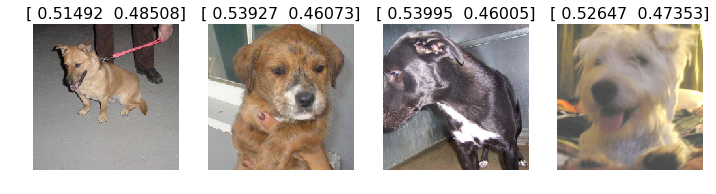

In [15]:
plot_incorrect(data.val_ds, fake_probs, from_class=1)

In [16]:
def plot_most_incorrect(dataset, probs, max_num_images=4, from_class=None, **kwargs):
    labels = dataset.y
    selected_prob = np.array([probs[i, label] for i, label in enumerate(labels)])
    errors = 1 - selected_prob
    dec_error_idxs = np.argsort(errors)[::-1]
    labels = labels[dec_error_idxs]
    
    if from_class is not None:
        dec_error_idxs = dec_error_idxs[labels == from_class]    

    plot_images(data.val_ds, dec_error_idxs[:max_num_images],
                titles=selected_prob[dec_error_idxs[:max_num_images]], **kwargs)

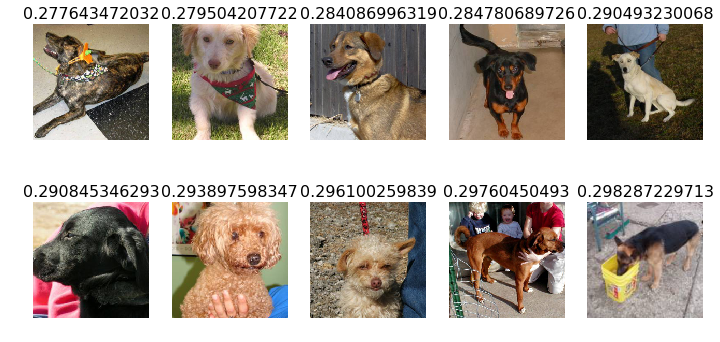

In [17]:
plot_most_incorrect(data.val_ds, fake_probs, from_class=1, max_num_images=10, rows=2)